In [76]:
import pandas as pd

df = pd.read_csv("enron_spam_data.csv")

In [98]:
df_spam = df[df["Spam/Ham"] == "spam"]
df_ham = df[df["Spam/Ham"] == "ham"]

class HamSpam:
    def __init__(self, df):
        self.df = df.sort_values("Date").fillna("")
        self.df = {
            "spam": self.df[self.df["Spam/Ham"] == "spam"],
            "ham": self.df[self.df["Spam/Ham"] == "ham"]
        }
        self.i = {
            "spam": 0,
            "ham": 0
        }
        self.curr = "spam"
    
    def __len__(self):
        return len(self.df["spam"]) + len(self.df["ham"])
    
    def reset(self):
        self.i = {
            "spam": 0,
            "ham": 0
        }
        self.curr = "spam"

    def get_sample(self):
        # alternate between ham and spam
        self.curr = "ham" if self.curr == "spam" else "spam"
        if self.i[self.curr] >= len(self.df[self.curr]):
            return None
        else:
            self.i[self.curr] += 1
            label = 1 if self.curr == "spam" else 0
            subject = self.df[self.curr].iloc[self.i[self.curr] - 1]["Subject"]
            text = self.df[self.curr].iloc[self.i[self.curr] - 1]["Message"]
            return subject, text, label
    
ds = HamSpam(df)
for i in range(10):
    print(ds.get_sample())
ds.reset()

('christmas tree farm pictures', '', 0)
('fw : this is the solution i mentioned lsc', 'oo\nthank you ,\nyour email address was obtained from a purchased list ,\nreference # 2020 mid = 3300 . if you wish to unsubscribe\nfrom this list , please click here and enter\nyour name into the remove box . if you have previously unsubscribed\nand are still receiving this message , you may email our abuse\ncontrol center , or call 1 - 888 - 763 - 2497 , or write us at : nospam ,\n6484 coral way , miami , fl , 33155 " . © 2002\nweb credit inc . all rights reserved .', 1)
('research group move to the 19 th floor', 'hello all :\nin case any of you feel energetic , " the boxes are here " . they are located\nat 2963 b ( michael sergeev \' s old desk ) . feel free to take as many as\nyou will need . be sure to label everything with your new office location .\nif your file cabinets lock , you can just label them and lock them .\nagain , listed below is your new office location :\nstinson gibner eb 1936\n

In [99]:
train_size = int(0.33 * len(ds))

def encode_email(email):
    subject, msg = email
    return f"{subject} {msg}"

subject_train, msg_train, y_train = zip(*[ ds.get_sample() for i in range(train_size) ])
text_train = list(map(encode_email, zip(subject_train, msg_train)))


In [100]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=10_000)
X_train = vectorizer.fit_transform(text_train).toarray()

df_train_1hot = pd.DataFrame(X_train >  0, columns=vectorizer.get_feature_names_out())

In [101]:
from divexp import compute_matches

matches_train = compute_matches(df_train_1hot, minsup=0.05)

In [102]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1)

In [103]:
batch_size = 512

text_test = []
y_test = []

while True:
    out = ds.get_sample()
    if out is None:
        break
    subject, msg, label = out

    text_test.append(encode_email((subject, msg)))
    y_test.append(label)

In [106]:
from divexp import div_explorer, Matches

In [107]:
from sklearn.metrics import accuracy_score, f1_score

matches_test = []
acc = []
f1 = []
divs = []

for i in range(0, len(text_test), batch_size):
    print(i)
    X_test_batch = vectorizer.transform(text_test[i:i+batch_size]).toarray()
    df_test_1hot = pd.DataFrame(X_test_batch > 0, columns=vectorizer.get_feature_names_out())
    
    m = compute_matches(df_test_1hot, fi=matches_train.fi)
    m = Matches(matches=m.matches.astype(int), fi=m.fi)
    matches_test.append(m)

    y_test_batch = y_test[i:i+batch_size]
    y_pred_batch = clf.predict(X_test_batch)

    acc.append(accuracy_score(y_test_batch, y_pred_batch))
    f1.append(f1_score(y_test_batch, y_pred_batch))

    divs.append(div_explorer(m, y_test_batch, y_pred_batch, []))

0
512
1024
1536
2048
2560
3072
3584
4096
4608
5120
5632
6144
6656
7168
7680
8192
8704
9216
9728
10240
10752
11264
11776
12288
12800
13312
13824
14336
14848
15360
15872
16384
16896
17408
17920
18432
18944
19456
19968
20480
20992
21504


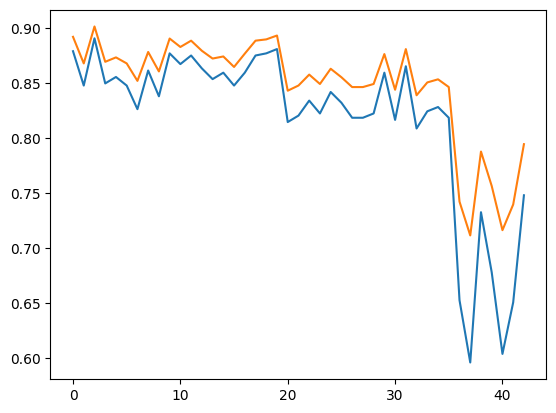

In [109]:
import matplotlib.pyplot as plt

plt.plot(acc)
plt.plot(f1)

In [117]:
(divs[-1][["tp", "fp", "fn", "tn"]].sum(axis=1) == 0).mean()

0.6572742955721679

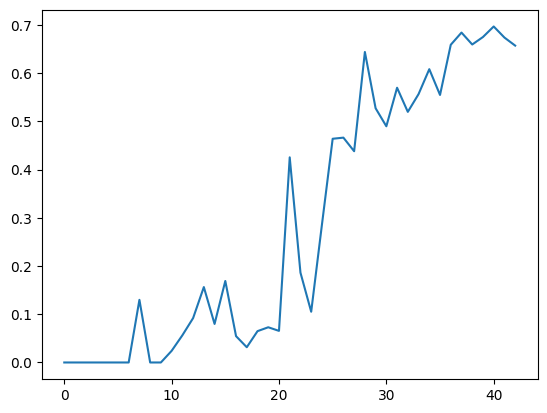

In [122]:
plt.plot([ (divs[i][["tp", "fp", "fn", "tn"]].sum(axis=1) == 0).mean() for i in range(len(divs)) ])

In [150]:
import numpy as np

mask_all = (np.vstack([ (divs[i][["tp", "fp", "fn", "tn"]].sum(axis=1) == 0).values for i in range(len(divs)) ]).sum(axis=0) == 0)

In [151]:
new_divs = [ d[mask_all].copy() for d in divs ]

In [152]:
from detect import detect_singlebatch

In [167]:
win_size = 10
delta, tstat = detect_singlebatch(new_divs, "accuracy", (0, win_size), (len(new_divs) - win_size, win_size))

In [198]:
tstat.sort_values(ascending=False)

191    44.363155
27     34.910954
170    29.764943
107    22.336934
149    20.542385
         ...    
654     0.000000
652     0.000000
648     0.000000
644     0.000000
700     0.000000
Length: 443, dtype: float64

In [199]:
tstat.sort_values(ascending=False).index

Index([ 191,   27,  170,  107,  149,   63,  181,  177,   75,   54,
       ...
       1464, 1465, 1466,  662,  660,  654,  652,  648,  644,  700],
      dtype='int64', length=443)

In [206]:
tstat.sort_values(ascending=False).index

Index([ 191,   27,  170,  107,  149,   63,  181,  177,   75,   54,
       ...
       1464, 1465, 1466,  662,  660,  654,  652,  648,  644,  700],
      dtype='int64', length=443)

In [207]:
matches_train.fi.loc[tstat.sort_values(ascending=False).index].itemsets

191                        (18)
27                       (4128)
170                      (8689)
107                        (10)
149                      (2922)
                 ...           
654    (3713, 2018, 9091, 8809)
652          (3713, 2018, 9091)
648          (3713, 2018, 8809)
644                (3713, 2018)
700            (2018, 9091, 44)
Name: itemsets, Length: 443, dtype: object

In [219]:
def map_to_names(x):
    return vectorizer.get_feature_names_out()[list(x)]
subgroups = matches_train.fi.loc[tstat.sort_values(ascending=False).index].itemsets.map(map_to_names)

In [220]:
subgroups.head(20)

191                [02]
27               [file]
170             [start]
107                [01]
149              [date]
63                 [12]
181          [required]
177           [details]
75                 [24]
54            [subject]
143                [21]
66                 [20]
1606    [subject, sent]
138                [15]
96               [sent]
87                 [13]
77                 [14]
133                [17]
190            [energy]
70             [number]
Name: itemsets, dtype: object

In [221]:
subgroups.tail(20)

1338                        [cc, corp]
526                      [let, cc, pm]
681                           [cc, 10]
1348               [subject, cc, corp]
1349                 [enron, cc, corp]
676                  [time, cc, enron]
520       [enron, cc, subject, 10, pm]
530                [know, let, cc, pm]
1458                    [cc, corp, pm]
531       [let, cc, subject, know, pm]
1464           [subject, cc, corp, pm]
1465             [enron, cc, corp, pm]
1466    [enron, cc, subject, corp, pm]
662          [com, enron, cc, subject]
660                   [com, enron, cc]
654       [enron, cc, thanks, subject]
652                [enron, cc, thanks]
648               [enron, cc, subject]
644                        [enron, cc]
700                   [cc, thanks, 10]
Name: itemsets, dtype: object

In [222]:
for d in new_divs:
    d["accuracy"] = (d["tp"] + d["tn"]) / (d["tp"] + d["tn"] + d["fp"] + d["fn"])

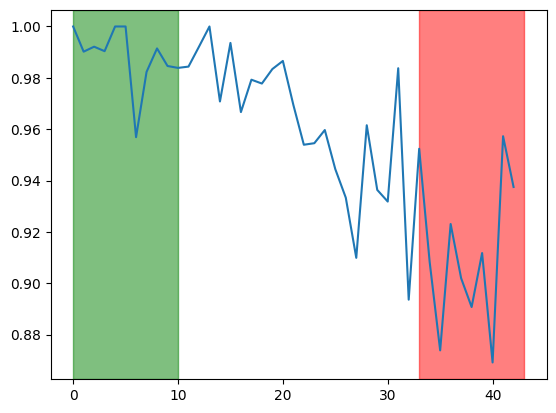

In [225]:
sg = 54

plt.plot([ d.loc[sg]["accuracy"] for d in new_divs ])
plt.axvspan(0, 0 + win_size, color="green", alpha=0.5)
plt.axvspan(len(new_divs) - win_size, len(new_divs), color="red", alpha=0.5)